This program uses artificial reccurent neural network called Long Short Term Memory (LSTM)
to predict closing stock price of a chosen stock or crypto, using past 60 day price.
Here, I'm using BTC-USD pair.

In [22]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [23]:
#Get the quote
df = web.DataReader('BTC-USD', data_source='yahoo', start='2012-01-01', end='2022-08-17')

#Show data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014
...,...,...,...,...,...,...
2022-08-14,24974.914062,24206.259766,24429.056641,24319.333984,22994133555,24319.333984
2022-08-15,25135.589844,23839.775391,24318.316406,24136.972656,35123501685,24136.972656
2022-08-16,24228.416016,23733.500000,24126.136719,23883.291016,27753685646,23883.291016


In [24]:
#Get the number of rows and columns in the dataset
df.shape

(2893, 6)

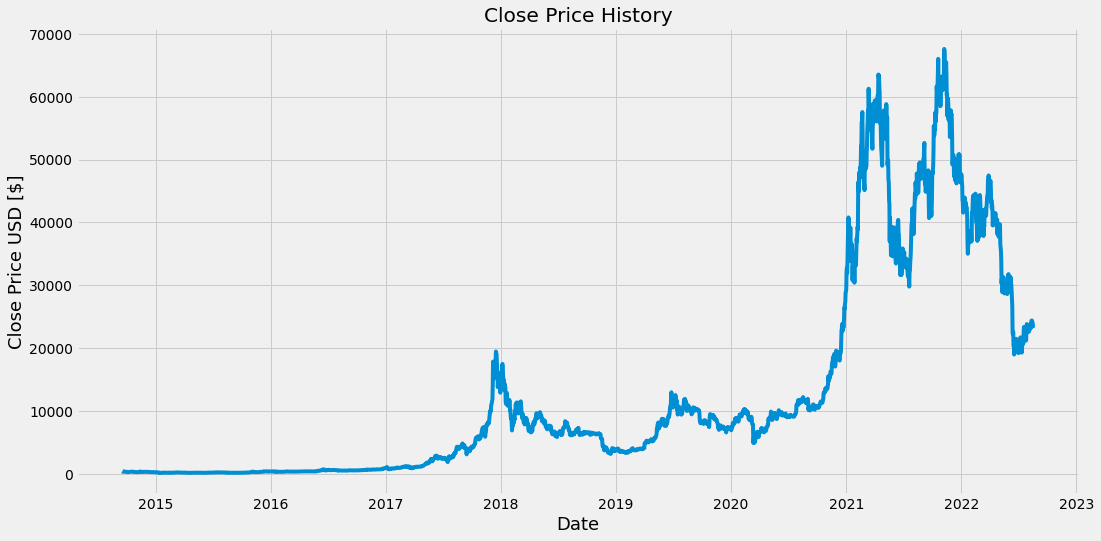

In [25]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD [$]', fontsize=18)
plt.show()

In [26]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Convert it to numpy array

dataset = data.values

#Get the number of rows to train the model on 80% of the data

training_data_len = math.ceil (len(dataset) * 0.8)
training_data_len

2315

In [27]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.35176787],
       [0.34364643],
       [0.34181735]])

In [28]:
#Create the training dataset
#Create the scaled training dataset, preserving all columns
train_data = scaled_data[0:training_data_len, :]

#Split the data into:
# x_train - independent training features, and 
# y_train - deepened target variables

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #60 values indexed from 0 to 59
    y_train.append(train_data[i, 0])  #value that we want our model to predict
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862])]
[0.0031129686946921404]

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.

In [29]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [30]:
#Reshape the data - LSTM expects the input to be 3D: number of samples, number of timesteps, number of features
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape 


(2255, 60, 1)

In [31]:
#Build the LSTM model
#.add(LSTM <- adding a LSTM layer
# 50 stands for number of neurons. 
# Return Sequences=true because we want to add another layer
#Input shape = (time steps, outcomes to predict)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25)) #densely connected layer with 25 neurons
model.add(Dense(1))

In [32]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#loss function measures how well the model did in training
#optimizer is used to improve upon the loss function

In [33]:
#Train the model
#batch_size is the total number of training examples present in a single batch
#epochs is the total number of iterations where an entire dataset is passed forward and backwards the network
model.fit(x_train, y_train, batch_size = 1, epochs=5)

Epoch 1/5
2255/2255 [==============================] - 35s 15ms/step - loss: 3.8875e-04
Epoch 2/5
2255/2255 [==============================] - 33s 15ms/step - loss: 2.0168e-04
Epoch 3/5
2255/2255 [==============================] - 33s 15ms/step - loss: 1.2442e-04
Epoch 4/5
2255/2255 [==============================] - 33s 15ms/step - loss: 2.2409e-04
Epoch 5/5
2255/2255 [==============================] - 33s 15ms/step - loss: 8.9873e-05


In [34]:
#Create the testing data set
#Create a new array containing scaled values from
test_data = scaled_data[training_data_len - 60: , :]

#Create the data set x_text and y_test

y_test = dataset[training_data_len:, :] #all of the values that we want our model to predict

x_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])



In [35]:
#Convert to numpy array 
x_test = np.array(x_test)

In [36]:
#Reshape the data to 3d again (LSTM expects this format)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [37]:
#Get the model predicted price values for x_test dataset

predictions = model.predict(x_test) #we want it to be exact same values that's in our y_test dataset contains
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 10ms/step


In [38]:
#Get root mean squared error (RMSE) (a good measure of how accurate the model is. lower values indicate a better fit)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse 

#0 means exact. as it happened (complete accuracy)
#normally other methods should also be used to evaluate accuracy

1954.5394258130066

C:\Users\Bruker\AppData\Local\Temp\ipykernel_15128\3863983177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


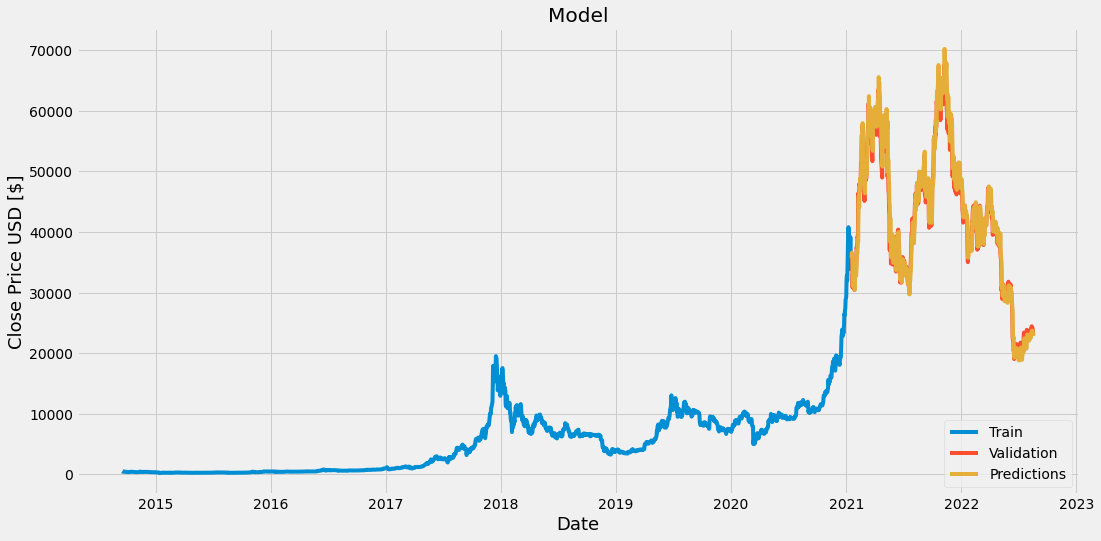

In [39]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions

#Visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD [$]', fontsize=18)

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [40]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-01-18,36630.074219,35730.375000
2021-01-19,36069.804688,36578.898438
2021-01-20,35547.750000,36023.285156
2021-01-21,30825.699219,35504.656250
2021-01-22,33005.761719,31053.287109
...,...,...
2022-08-14,24319.333984,23715.736328
2022-08-15,24136.972656,23636.792969
2022-08-16,23883.291016,23491.126953


In [41]:
#Try and predict the closing price for tommorow (18.08.22)
#Get the Quote

get_quote=web.DataReader('BTC-USD', data_source='yahoo', start='2012-01-01', end='2022-08-18')

#Create a new dataframe

new_df = get_quote.filter(['Close'])

#Get the last 60 day closing values and conver the df to an array
last_60_days = new_df[-60:].values

#Scale the data to eb values between 0-1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list
X_test = []

#Append the past 60 days - scaled - to the list
X_test.append(last_60_days_scaled)

#Convert to np.array so we can use it in the model, reshape for same reason
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = model.predict(X_test)

#undo the scaling so we can read it
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 17ms/step
[[20711.744]]


In [42]:
#Get the Quote

get_quote2 = web.DataReader('BTC-USD', data_source='yahoo', start='2022-08-17', end='2022-08-17')
print(get_quote2['Close'])

Date
2022-08-17    23335.998047
2022-08-18    23212.738281
Name: Close, dtype: float64
